In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits import mplot3d
import numpy as np
import json
import ast
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

df = pd.read_csv("../2_clean_data/final_combine_data.csv")

In [3]:
#Columns with lists are represented as strings, so this is converting them into list/np.array types

for index, row in df.iterrows():
    df.iloc[index]['salaries'] = ast.literal_eval(df.iloc[index]['salaries'])
    df.iloc[index]['semester'] = ast.literal_eval(df.iloc[index]['semester'])
    df.iloc[index]['years_taught'] = ast.literal_eval(df.iloc[index]['years_taught'])
    df.iloc[index]['course'] = ast.literal_eval(df.iloc[index]['course'])
    df.iloc[index]['average_rating'] = np.fromstring(df.iloc[index]['average_rating'].strip("[]"), sep=',')
    df.iloc[index]['num_reviews'] = np.fromstring(df.iloc[index]['num_reviews'].strip("[]"), sep=',')
    df.iloc[index]['average_gpa'] = np.fromstring(df.iloc[index]['average_gpa'].strip("[]"), sep=',')
    df.iloc[index]['num_students'] = ast.literal_eval(df.iloc[index]['num_students'])

In [4]:
import re
df = df.drop([1615, 1616])
# Getting the minimum year
df['min_year'] = df['years_taught'].apply(lambda x: min([sem for sem in x]))
# Getting lifespan of professor from first year taught to current semester that is being taught
df['year'] = df['semester'].apply(lambda x: min([sem.split(" ")[1] for sem in x]))
df['min_year'] = df[['min_year', 'year']].min(axis=1)
df = df.drop(['year'], axis=1)
df = df.explode(['course', 'semester', 'average_rating', 'num_reviews', 'average_gpa', 'num_students'])
df['curr_year'] = df['semester'].apply(lambda x: int(x.split(" ")[1]))
df['lifetime'] = df['curr_year'] - df['min_year']
df.loc[df['lifetime'] < 0, 'lifetime'] = np.nan


/tmp/ipykernel_10018/2488250113.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df['min_year'] = df[['min_year', 'year']].min(axis=1)


In [6]:
# Getting current salary
# get the current year, get the index in years taught, get the value of salaries at that index
def getIndex(year, array):
    differenceArray = np.absolute(np.array(array)-year)
    return differenceArray.argmin()
def getSalary(index, salary):
    return salary[index]
df['index'] = df.apply(lambda x: getIndex(x['curr_year'], x['years_taught']), axis=1)
df['current_salary'] = df.apply(lambda x: getSalary(x['index'], x['salaries']), axis=1)
df = df.drop('index', axis=1)

In [7]:
# Getting and splitting dataset into training and testing data

lifeTimeGrades = df[['lifetime', 'average_gpa']]
lifeTimeGrades.dropna(inplace=True)
lifeTimeRating = df[['lifetime', 'average_rating']]
lifeTimeRating.dropna(inplace=True)
salaryGrades = df[['current_salary', 'average_gpa']]
salaryGrades.dropna(inplace=True)
salaryRating = df[['current_salary', 'average_rating']]
salaryRating.dropna(inplace=True)
lsGrades = df[['lifetime', 'current_salary', 'average_gpa']]
lsGrades.dropna(inplace=True)
lsRating = df[['lifetime', 'current_salary', 'average_rating']]
lsRating.dropna(inplace=True)


/tmp/ipykernel_10018/520331999.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lifeTimeGrades.dropna(inplace=True)
/tmp/ipykernel_10018/520331999.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lifeTimeRating.dropna(inplace=True)
/tmp/ipykernel_10018/520331999.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salaryGrades.dropna(inplace=True)
/tmp/ipykernel_10018/520331999.py:10: SettingWithCopyWarning: 
A value is trying to 

0.007494962188835386


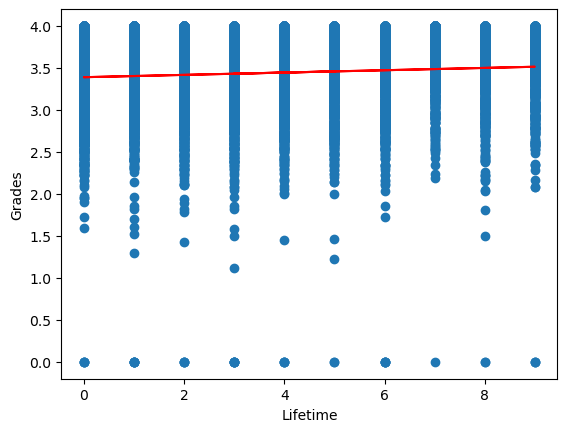

-0.002290904900294377


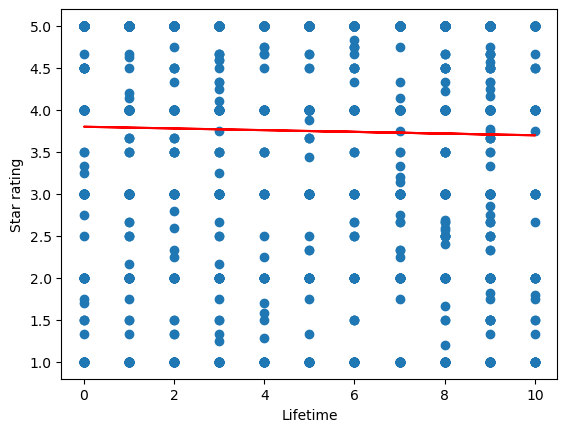

0.00011166583628685611


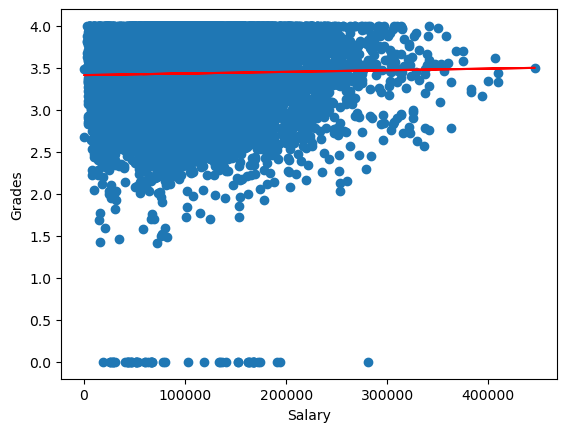

0.00449115383078158


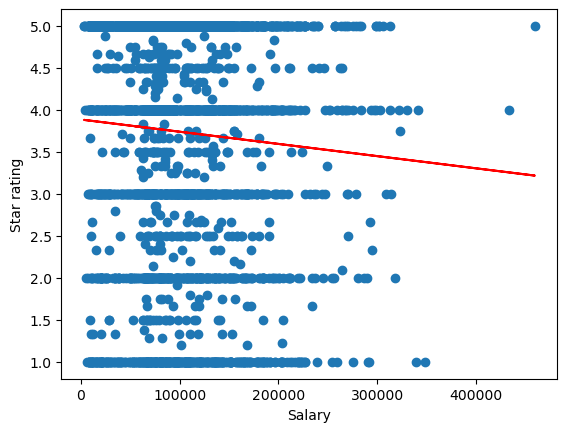

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


0.0062953816186408496


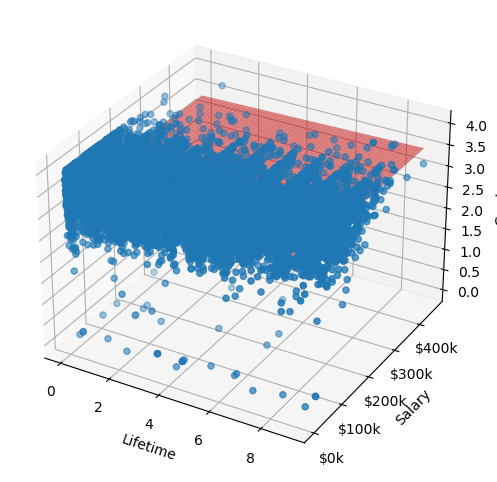

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


0.005663908970584219


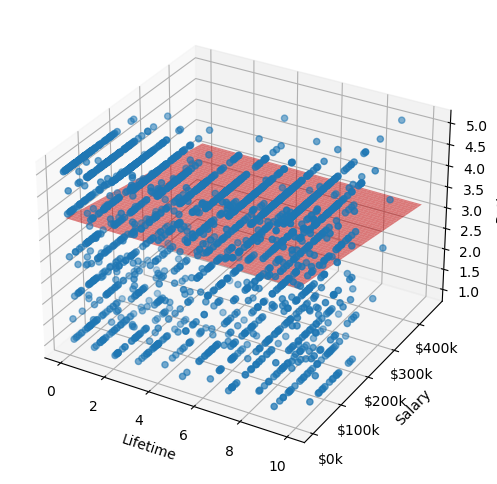

In [8]:
import sklearn.model_selection
import sklearn.linear_model
# Linear Regression Analysis

# Regression of lifetime vs grades
lifetime_train, lifetime_test, grade_train, grade_test = sklearn.model_selection.train_test_split(lifeTimeGrades['lifetime'], lifeTimeGrades['average_gpa'], test_size=0.3)
linear = sklearn.linear_model.LinearRegression().fit(np.array(lifetime_train).reshape(-1,1), grade_train)
print(linear.score(np.array(lifetime_test).reshape(-1,1), grade_test))
gradePredict = linear.predict(np.array(lifetime_test).reshape(-1,1))
plt.scatter(np.array(lifetime_test).reshape(-1,1), grade_test)
plt.plot(np.array(lifetime_test).reshape(-1,1), gradePredict, color='red')
plt.xlabel('Lifetime')
plt.ylabel('Grades')
plt.show()

# Regression of lifetime vs starRating
lifetime_train, lifetime_test, rating_train, rating_test = sklearn.model_selection.train_test_split(lifeTimeRating['lifetime'], lifeTimeRating['average_rating'], test_size=0.3)
linear = sklearn.linear_model.LinearRegression().fit(np.array(lifetime_train).reshape(-1,1), rating_train)
print(linear.score(np.array(lifetime_test).reshape(-1,1), rating_test))
ratingPredict = linear.predict(np.array(lifetime_test).reshape(-1,1))
plt.scatter(np.array(lifetime_test).reshape(-1,1), rating_test)
plt.plot(np.array(lifetime_test).reshape(-1,1), ratingPredict, color='red')
plt.xlabel('Lifetime')
plt.ylabel('Star rating')
plt.show()

# Regression of salary vs grades
salary_train, salary_test, grade_train, grade_test = sklearn.model_selection.train_test_split(salaryGrades['current_salary'], salaryGrades['average_gpa'], test_size=0.3)
linear = sklearn.linear_model.LinearRegression().fit(np.array(salary_train).reshape(-1,1), grade_train)
print(linear.score(np.array(salary_test).reshape(-1,1), grade_test))
gradePredict = linear.predict(np.array(salary_test).reshape(-1,1))
plt.scatter(np.array(salary_test).reshape(-1,1), grade_test)
plt.plot(np.array(salary_test).reshape(-1,1), gradePredict, color='red')
plt.xlabel('Salary')
plt.ylabel('Grades')
plt.show()
# Regression of salary vs starRating
salary_train, salary_test, rating_train, rating_test = sklearn.model_selection.train_test_split(salaryRating['current_salary'], salaryRating['average_rating'], test_size=0.3)
linear = sklearn.linear_model.LinearRegression().fit(np.array(salary_train).reshape(-1,1), rating_train)
print(linear.score(np.array(salary_test).reshape(-1,1), rating_test))
ratingPredict = linear.predict(np.array(salary_test).reshape(-1,1))
plt.scatter(np.array(salary_test).reshape(-1,1), rating_test)
plt.plot(np.array(salary_test).reshape(-1,1), ratingPredict, color='red')
plt.xlabel('Salary')
plt.ylabel('Star rating')
plt.show()

# 3d Regression of salary and lifetime as x variables and grades as y variable
X = lsGrades.drop('average_gpa', axis=1)
y = lsGrades['average_gpa']
ls_train, ls_test, grade_train, grade_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3)
linear = sklearn.linear_model.LinearRegression().fit(np.array(ls_train), grade_train)
print(linear.score(ls_test, grade_test))
gradePredict = linear.predict(ls_test)

fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')

ax.scatter3D(ls_test['lifetime'], ls_test['current_salary'], grade_test)
ax.set_xlabel('Lifetime')
ax.set_ylabel('Salary')
ax.set_zlabel('Grades')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${x/1000:.0f}k'))

#Create a meshgrid for the linear regression surface plot
x = np.linspace(min(ls_test['lifetime']), max(ls_test['lifetime']), 100)
y = np.linspace(min(ls_test['current_salary']), max(ls_test['current_salary']), 100)
X, Y = np.meshgrid(x, y)

#Predict GPA values
Z = linear.predict(np.column_stack((X.ravel(), Y.ravel())))
Z = Z.reshape(X.shape)

ax.plot_surface(X, Y, Z, color='r', alpha=0.5, label='Regression Plane')
plt.show()

# 3d Regression of salary and lifetime as x variables and star rating as y variable
X = lsRating.drop('average_rating', axis=1)
y = lsRating['average_rating']
ls_train, ls_test, rating_train, rating_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3)
linear = sklearn.linear_model.LinearRegression().fit(np.array(ls_train), rating_train)
print(linear.score(ls_test, rating_test))
ratingPredict = linear.predict(ls_test)

fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')

ax.scatter3D(ls_test['lifetime'], ls_test['current_salary'], rating_test)
ax.set_xlabel('Lifetime')
ax.set_ylabel('Salary')
ax.set_zlabel('Rating')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${x/1000:.0f}k'))

#Create a meshgrid for the linear regression surface plot
x = np.linspace(min(ls_test['lifetime']), max(ls_test['lifetime']), 100)
y = np.linspace(min(ls_test['current_salary']), max(ls_test['current_salary']), 100)
X, Y = np.meshgrid(x, y)

#Predict GPA values
Z = linear.predict(np.column_stack((X.ravel(), Y.ravel())))
Z = Z.reshape(X.shape)

ax.plot_surface(X, Y, Z, color='r', alpha=0.5, label='Regression Plane')
plt.show()

0.7595029837325268


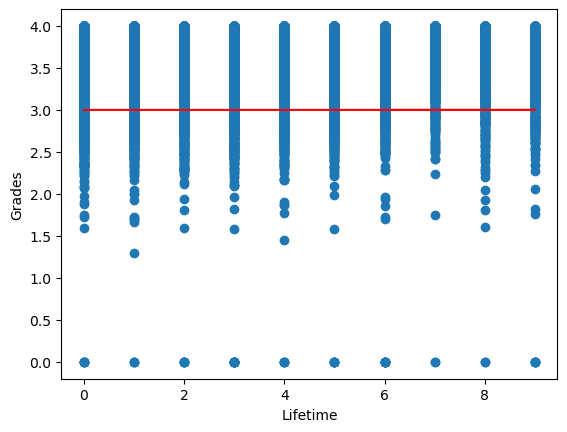

0.4520098441345365


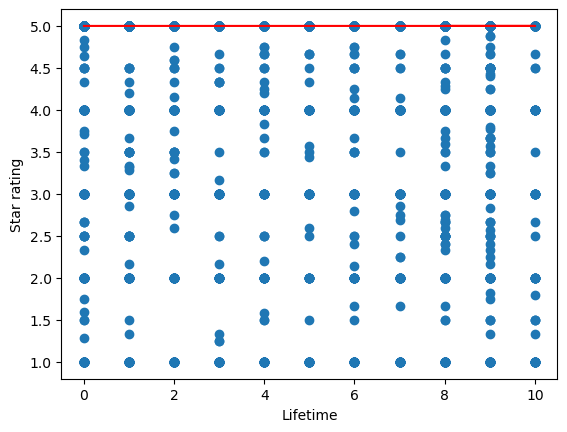

0.7556597552934281


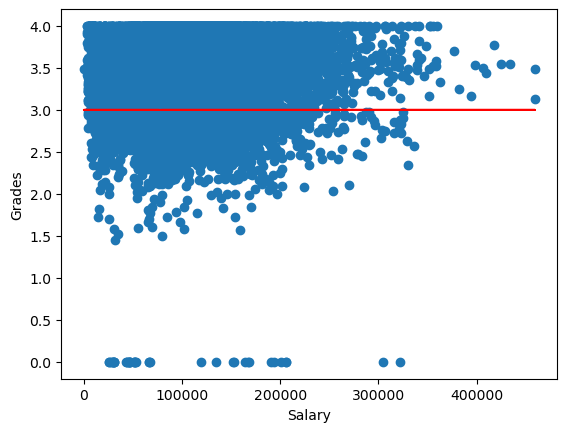

0.4231974921630094


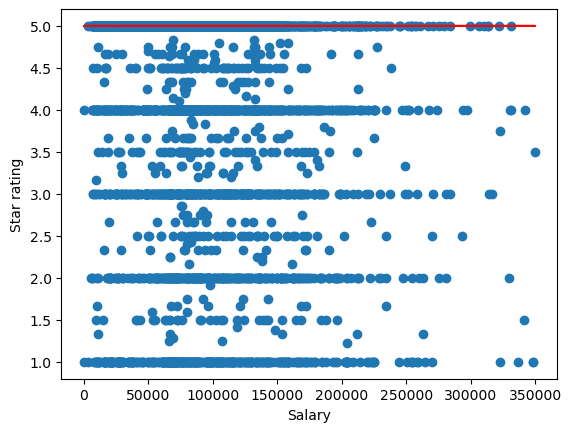

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


0.7588490149595357


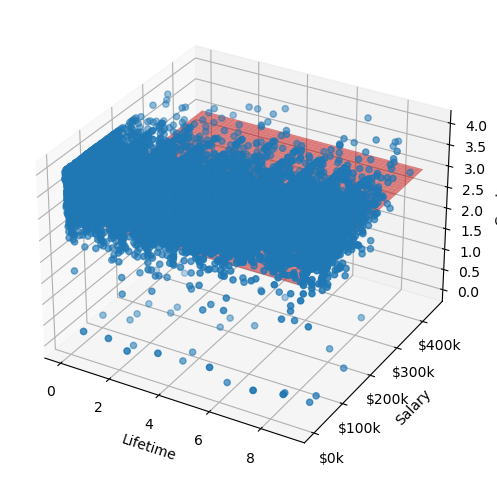

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


0.4610336341263331


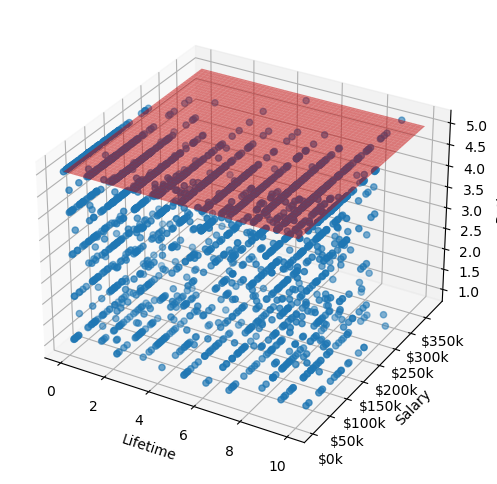

In [9]:
# The reason it shows up as a straight line is because it is the beginning / the end of the log function so it is only showing the straight line portion of the graph

#Regression of liftime vs grades
lifetime_train, lifetime_test, grade_train, grade_test = sklearn.model_selection.train_test_split(lifeTimeGrades['lifetime'], lifeTimeGrades['average_gpa'], test_size=0.3)
logistic = sklearn.linear_model.LogisticRegression().fit(np.array(lifetime_train).reshape(-1,1), grade_train.astype('int'))
print(logistic.score(np.array(lifetime_test).reshape(-1,1), grade_test.astype('int')))
gradePredict = logistic.predict(np.array(lifetime_test).reshape(-1,1))
plt.scatter(np.array(lifetime_test).reshape(-1,1), grade_test)
plt.plot(np.array(lifetime_test).reshape(-1,1), gradePredict, color='red')
plt.xlabel('Lifetime')
plt.ylabel('Grades')
plt.show()

# Regression of lifetime vs starRating
lifetime_train, lifetime_test, rating_train, rating_test = sklearn.model_selection.train_test_split(lifeTimeRating['lifetime'], lifeTimeRating['average_rating'], test_size=0.3)
logistic = sklearn.linear_model.LogisticRegression().fit(np.array(lifetime_train).reshape(-1,1), rating_train.astype('int'))
print(logistic.score(np.array(lifetime_test).reshape(-1,1), rating_test.astype('int')))
ratingPredict = logistic.predict(np.array(lifetime_test).reshape(-1,1))
plt.scatter(np.array(lifetime_test).reshape(-1,1), rating_test)
plt.plot(np.array(lifetime_test).reshape(-1,1), ratingPredict, color='red')
plt.xlabel('Lifetime')
plt.ylabel('Star rating')
plt.show()

# Regression of salary vs grades
salary_train, salary_test, grade_train, grade_test = sklearn.model_selection.train_test_split(salaryGrades['current_salary'], salaryGrades['average_gpa'], test_size=0.3)
logistic = sklearn.linear_model.LogisticRegression().fit(np.array(salary_train).reshape(-1,1), grade_train.astype('int'))
print(logistic.score(np.array(salary_test).reshape(-1,1), grade_test.astype('int')))
gradePredict = logistic.predict(np.array(salary_test).reshape(-1,1))
plt.scatter(np.array(salary_test).reshape(-1,1), grade_test)
plt.plot(np.array(salary_test).reshape(-1,1), gradePredict, color='red')
plt.xlabel('Salary')
plt.ylabel('Grades')
plt.show()

# Regression of salary vs starRating
salary_train, salary_test, rating_train, rating_test = sklearn.model_selection.train_test_split(salaryRating['current_salary'], salaryRating['average_rating'], test_size=0.3)
logistic = sklearn.linear_model.LogisticRegression().fit(np.array(salary_train).reshape(-1,1), rating_train.astype('int'))
print(logistic.score(np.array(salary_test).reshape(-1,1), rating_test.astype('int')))
ratingPredict = logistic.predict(np.array(salary_test).reshape(-1,1))
plt.scatter(np.array(salary_test).reshape(-1,1), rating_test)
plt.plot(np.array(salary_test).reshape(-1,1), ratingPredict, color='red')
plt.xlabel('Salary')
plt.ylabel('Star rating')
plt.show()

# 3d Regression of salary and lifetime as x variables and grades as y variable
X = lsGrades.drop('average_gpa', axis=1)
y = lsGrades['average_gpa']
ls_train, ls_test, grade_train, grade_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3)
logistic = sklearn.linear_model.LogisticRegression().fit(np.array(ls_train), grade_train.astype('int'))
print(logistic.score(ls_test, grade_test.astype('int')))
gradePredict = logistic.predict(ls_test)

fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')

ax.scatter3D(ls_test['lifetime'], ls_test['current_salary'], grade_test)
ax.set_xlabel('Lifetime')
ax.set_ylabel('Salary')
ax.set_zlabel('Grades')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${x/1000:.0f}k'))

#Create a meshgrid for the logistic regression surface plot
x = np.linspace(min(ls_test['lifetime']), max(ls_test['lifetime']), 100)
y = np.linspace(min(ls_test['current_salary']), max(ls_test['current_salary']), 100)
X, Y = np.meshgrid(x, y)

#Predict GPA values
Z = logistic.predict(np.column_stack((X.ravel(), Y.ravel())))
Z = Z.reshape(X.shape)

ax.plot_surface(X, Y, Z, color='r', alpha=0.5, label='Regression Plane')
plt.show()




# 3d Regression of salary and lifetime as x variables and star rating as y variable
X = lsRating.drop('average_rating', axis=1)
y = lsRating['average_rating']
ls_train, ls_test, rating_train, rating_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3)
logistic = sklearn.linear_model.LogisticRegression().fit(np.array(ls_train), rating_train.astype('int'))
print(logistic.score(ls_test, rating_test.astype('int')))
ratingPredict = logistic.predict(ls_test)

fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')

ax.scatter3D(ls_test['lifetime'], ls_test['current_salary'], rating_test)
ax.set_xlabel('Lifetime')
ax.set_ylabel('Salary')
ax.set_zlabel('Rating')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${x/1000:.0f}k'))

#Create a meshgrid for the logistic regression surface plot
x = np.linspace(min(ls_test['lifetime']), max(ls_test['lifetime']), 100)
y = np.linspace(min(ls_test['current_salary']), max(ls_test['current_salary']), 100)
X, Y = np.meshgrid(x, y)

#Predict GPA values
Z = logistic.predict(np.column_stack((X.ravel(), Y.ravel())))
Z = Z.reshape(X.shape)

ax.plot_surface(X, Y, Z, color='r', alpha=0.5, label='Regression Plane')
plt.show()

In [10]:
def addCategorizedGrade(data):
    data['categorized_grade'] = ""
    for index, row in data.iterrows():
        if row['average_gpa'] > 3.7:
            data.loc[index, 'categorized_grade'] = "A"
        elif row['average_gpa'] > 3.3:
            data.loc[index, 'categorized_grade'] = "A-"
        elif row['average_gpa'] > 3.0:
            data.loc[index, 'categorized_grade'] = "B+"
        elif row['average_gpa'] > 2.7:
            data.loc[index, 'categorized_grade'] = "B"
        elif row['average_gpa'] > 2.3:
            data.loc[index, 'categorized_grade'] = "B-"
        elif row['average_gpa'] > 2.0:
            data.loc[index, 'categorized_grade'] = "C+"
        elif row['average_gpa'] > 1.7:
            data.loc[index, 'categorized_grade'] = "C"
        elif row['average_gpa'] > 1.3:
            data.loc[index, 'categorized_grade'] = "C-"
        elif row['average_gpa'] > 1.0:
            data.loc[index, 'categorized_grade'] = "D+"
        elif row['average_gpa'] > 0.7:
            data.loc[index, 'categorized_grade'] = "D"
        else:
            data.loc[index, 'categorized_grade'] = "F"

In [11]:
# Creating categorized values for our classifiers

df_svm = df.copy()
df_svm = df_svm[df_svm['average_gpa'].notna() & df_svm['lifetime'].notna()]

teacherLifetimeGrades = df[(df['lifetime'].notna()) & (df['average_gpa'].notna())]
teacherLifetimeRating = df[(df['lifetime'].notna()) & (df['average_rating'].notna())]
salaryGrades = df[(df['current_salary'].notna()) & (df['average_gpa'].notna())]
salaryRating = df[(df['current_salary'].notna()) & (df['average_rating'].notna())]
lsGrades = df[(df['lifetime'].notna()) & (df['current_salary'].notna()) & (df['average_gpa'].notna())]
lsRating = df[(df['lifetime'].notna()) & (df['current_salary'].notna()) & (df['average_rating'].notna())]

addCategorizedGrade(teacherLifetimeGrades)
addCategorizedGrade(salaryGrades)
addCategorizedGrade(lsGrades)

teacherLifetimeGrades = teacherLifetimeGrades[['lifetime', 'categorized_grade']]
teacherLifetimeRating = teacherLifetimeRating[['lifetime', 'average_rating']]
salaryGrades = salaryGrades[['current_salary', 'categorized_grade']]
salaryRating = salaryRating[['current_salary', 'average_rating']]
lsGrades = lsGrades[['lifetime', 'current_salary', 'categorized_grade']]
lsRating = lsRating[['lifetime', 'current_salary', 'average_rating']]

#categorize rating data
teacherLifetimeRating['average_rating'] = teacherLifetimeRating['average_rating'].astype(int) 
salaryRating['average_rating'] = salaryRating['average_rating'].astype(int) 
lsRating['average_rating'] = lsRating['average_rating'].astype(int) 

#teacherLifetime = df_svm['lifetime']
#teacherSalaries = df_svm['current_salary']

# grades = df_svm['average_gpa']
# starRating = df_svm['average_rating']
# nlpRating = []
# df_svm['lifetimeSalary'] = [list(elt) for elt in zip(teacherLifetime, teacherSalaries)]
# categorizedGrade = []
#grades.dropna(inplace=True)



# lifeTimeGrades = df_svm[['lifetime', 'average_gpa']]
# #lifeTimeGrades.dropna(inplace=True)
# lifeTimeRating = df_svm[['lifetime', 'average_rating']]
# #lifeTimeRating.dropna(inplace=True)
# salaryGrades = df_svm[['current_salary', 'average_gpa']]
# #salaryGrades.dropna(inplace=True)
# salaryRating = df_svm[['current_salary', 'average_rating']]
# #salaryRating.dropna(inplace=True)
# lsGrades = df_svm[['lifetime', 'current_salary', 'average_gpa']]
# #lsGrades.dropna(inplace=True)
# lsRating = df_svm[['lifetime', 'current_salary', 'average_rating']]
# #lsRating.dropna(inplace=True)

# starRating.dropna(inplace=True)
# categorizedRating = [int(rating) for rating in starRating]


/tmp/ipykernel_10018/2160808469.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['categorized_grade'] = ""
/tmp/ipykernel_10018/2160808469.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['categorized_grade'] = ""
/tmp/ipykernel_10018/2160808469.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [12]:
def performanceMetrics(groundTruth, predictions):
    accuracy = accuracy_score(groundTruth, predictions)
    return accuracy

In [146]:
# SVM Analysis

# # SVM of lifetime and grades
# lifetime_train, lifetime_test, grade_train, grade_test = sklearn.model_selection.train_test_split(teacherLifetimeGrades['lifetime'], teacherLifetimeGrades['categorized_grade'], test_size=0.3)
# svm = sklearn.svm.SVC().fit(np.array(lifetime_train).reshape(-1,1), grade_train)
# svm.score(np.array(lifetime_test).reshape(-1,1), grade_test)
# gradePredict = svm.predict(np.array(lifetime_test).reshape(-1,1))

# print("Accuracy of SVM of lifetime and grades:", performanceMetrics(grade_test, gradePredict))



# SVM of lifetime and ratings
# lifetime_train, lifetime_test, rating_train, rating_test = sklearn.model_selection.train_test_split(teacherLifetimeRating['lifetime'], teacherLifetimeRating['average_rating'], test_size=0.3)
# svm = sklearn.svm.SVC().fit(np.array(lifetime_train).reshape(-1,1), rating_train)
# svm.score(np.array(lifetime_test).reshape(-1,1), rating_test)
# ratingPredict = svm.predict(np.array(lifetime_test).reshape(-1,1))

# print("Accuracy of SVM of lifetime and grades:", performanceMetrics(rating_test, ratingPredict))

# # SVM of salary and grades
# salary_train, salary_test, grade_train, grade_test = sklearn.model_selection.train_test_split(salaryGrades['current_salary'], salaryGrades['categorized_grade'], test_size=0.3)
# svm = sklearn.svm.SVC().fit(np.array(salary_train).reshape(-1,1), grade_train)
# svm.score(np.array(salary_test).reshape(-1,1), grade_test)
# gradePredict = svm.predict(np.array(salary_test).reshape(-1,1))

# print("Accuracy of SVM of salary and grades:", performanceMetrics(grade_test, gradePredict))

# # SVM of salary and ratings
# salary_train, salary_test, rating_train, rating_test = sklearn.model_selection.train_test_split(salaryRating['current_salary'], salaryRating['average_rating'], test_size=0.3)
# svm = sklearn.svm.SVC().fit(np.array(salary_train).reshape(-1,1), rating_train)
# svm.score(np.array(salary_test).reshape(-1,1), rating_test)
# ratingPredict = svm.predict(np.array(salary_test).reshape(-1,1))

# print("Accuracy of SVM of salary and ratings:", performanceMetrics(rating_test, ratingPredict))

#SVM of lifetime and salary vs grades
ls_train, ls_test, grade_train, grade_test = sklearn.model_selection.train_test_split(lsGrades[['lifetime', 'current_salary']], lsGrades['categorized_grade'], test_size=0.3)
svm = sklearn.svm.SVC().fit(np.array(ls_train), grade_train)
svm.score(np.array(ls_test), grade_test)
gradePredict = svm.predict(np.array(ls_test))

print("Accuracy of SVM of lifetime and salary and grades:", performanceMetrics(grade_test, gradePredict))

#SVM of lifetime and salary vs rating
ls_train, ls_test, rating_train, rating_test = sklearn.model_selection.train_test_split(lsRating[['lifetime', 'current_salary']], lsRating['average_rating'], test_size=0.3)
svm = sklearn.svm.SVC().fit(ls_train, rating_train)
ratingPredict = svm.predict(ls_test)

print("Accuracy of SVM of lifetime and salary and rating:", performanceMetrics(rating_test, ratingPredict))

Accuracy of SVM of lifetime and salary and grades: 0.5548925038829395
Accuracy of SVM of lifetime and salary and rating: 0.4495488105004102


In [14]:
#display(pd.DataFrame(grade_test))
print(np.unique(ratingPredict))
print(np.unique(gradePredict))

[5]
[3]


In [15]:
# KNN Analysis

# # KNN of lifetime and grade
# lifetime_train, lifetime_test, grade_train, grade_test = sklearn.model_selection.train_test_split(teacherLifetimeGrades['lifetime'], teacherLifetimeGrades['categorized_grade'], test_size=0.3)
# knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5).fit(np.array(lifetime_train).reshape(-1,1), grade_train)
# knn.score(np.array(lifetime_test).reshape(-1,1), grade_test)
# gradePredict = knn.predict(np.array(lifetime_test).reshape(-1,1))

# print("Accuracy of KNN of lifetime and grades:", performanceMetrics(grade_test, gradePredict))

# df_lg = pd.DataFrame({"lifetime_test":lifetime_test, "gradeActual":grade_test, "gradePredict":gradePredict})



# # KNN of lifetime and rating
# lifetime_train, lifetime_test, rating_train, rating_test = sklearn.model_selection.train_test_split(teacherLifetimeRating['lifetime'], teacherLifetimeRating['average_rating'], test_size=0.3)
# knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5).fit(np.array(lifetime_train).reshape(-1,1), rating_train)
# knn.score(np.array(lifetime_test).reshape(-1,1), rating_test)
# ratingPredict = knn.predict(np.array(lifetime_test).reshape(-1,1))

# print("Accuracy of KNN of lifetime and rating:", performanceMetrics(rating_test, ratingPredict))

# df_lr = pd.DataFrame({"lifetime_test":lifetime_test, "ratingActual":rating_test, "ratingPredict":ratingPredict})


# # KNN of salary and grade
# salary_train, salary_test, grade_train, grade_test = sklearn.model_selection.train_test_split(salaryGrades['current_salary'], salaryGrades['categorized_grade'], test_size=0.3)
# knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5).fit(np.array(salary_train).reshape(-1,1), grade_train)
# knn.score(np.array(salary_test).reshape(-1,1), grade_test)
# gradePredict = knn.predict(np.array(salary_test).reshape(-1,1))

# print("Accuracy of KNN of salary and grades:", performanceMetrics(grade_test, gradePredict))

# # KNN of salary and rating
# salary_train, salary_test, rating_train, rating_test = sklearn.model_selection.train_test_split(salaryRating['current_salary'], salaryRating['average_rating'], test_size=0.3)
# knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5).fit(np.array(salary_train).reshape(-1,1), rating_train)
# knn.score(np.array(salary_test).reshape(-1,1), rating_test)
# ratingPredict = knn.predict(np.array(salary_test).reshape(-1,1))

# print("Accuracy of KNN of salary and rating:", performanceMetrics(rating_test, ratingPredict))


# KNN of lifetime and salary vs grade
ls_train, ls_test, grade_train, grade_test = sklearn.model_selection.train_test_split(lsGrades[['lifetime', 'current_salary']], lsGrades['categorized_grade'], test_size=0.3)
lsg_knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5).fit(np.array(ls_train), grade_train)
lsg_knn.score(np.array(ls_test), grade_test)
gradePredict = lsg_knn.predict(ls_test)

print("Accuracy of KNN of lifetime and salary vs grade:", performanceMetrics(grade_test, gradePredict))
df_lsg = pd.DataFrame({"lifetime":ls_test['lifetime'], "salary":ls_test['current_salary'], "gradeActual": grade_test, "gradePredict":gradePredict})

# KNN of lifetime and salary vs rating
ls_train, ls_test, rating_train, rating_test = sklearn.model_selection.train_test_split(lsRating[['lifetime', 'current_salary']], lsRating['average_rating'], test_size=0.3)
lsr_knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5).fit(np.array(ls_train), rating_train)
lsr_knn.score(np.array(ls_test), rating_test)
ratingPredict = lsr_knn.predict(ls_test)

print("Accuracy of KNN of lifetime and salary vs rating:", performanceMetrics(rating_test, ratingPredict))
df_lsr = pd.DataFrame({"lifetime":ls_test['lifetime'], "salary":ls_test['current_salary'],  "ratingActual": rating_test, "ratingPredict":ratingPredict})

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Accuracy of KNN of lifetime and salary vs grade: 0.6886291179596175
Accuracy of KNN of lifetime and salary vs rating: 0.3424938474159147


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


In [16]:
xx, yy = np.meshgrid(np.arange(ls_test['lifetime'].min(), ls_test['lifetime'].max(), .1),np.linspace(ls_test['current_salary'].min(), ls_test['current_salary'].max(), 1000))
onlyX = pd.DataFrame({'lifetime': xx.ravel(), 'current_salary': yy.ravel()})
fittedY=lsr_knn.predict(onlyX)
fittedY=np.array(fittedY)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


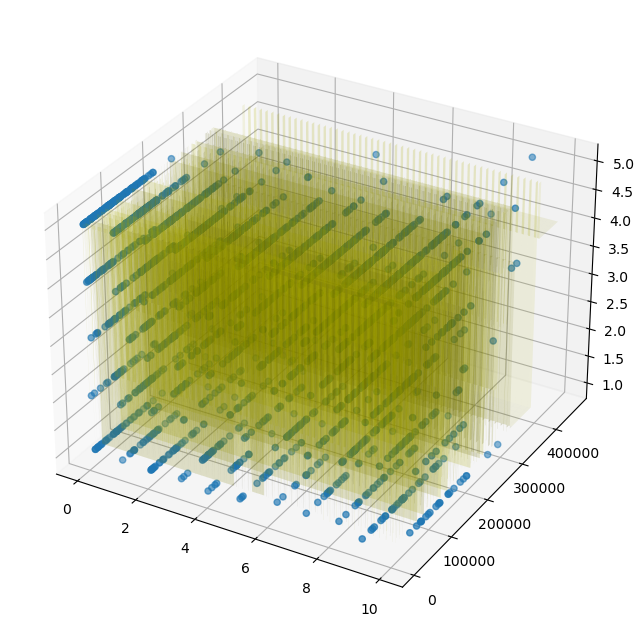

In [17]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(ls_test['lifetime'], ls_test['current_salary'], rating_test, marker="o")
ax.plot_surface(xx,yy,fittedY.reshape(xx.shape), color='y', alpha=0.1)


In [19]:
from sklearn import tree
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier


classifierList = {"Decision Tree": tree.DecisionTreeClassifier(), "Random Forest": RandomForestClassifier(max_depth=5, random_state=0)}

for name in classifierList:
    #lifetime and salary vs grade
    ls_train, ls_test, grade_train, grade_test = sklearn.model_selection.train_test_split(lsGrades[['lifetime', 'current_salary']], lsGrades['categorized_grade'], test_size=0.3)
    lsg = classifierList[name].fit(np.array(ls_train), grade_train)
    lsg.score(np.array(ls_test), grade_test)
    gradePredict = lsg.predict(ls_test)

    print("Accuracy of " + name + " of lifetime and salary vs grade:", performanceMetrics(grade_test, gradePredict))
    #df_lsg = pd.DataFrame({"lifetime":ls_test['lifetime'], "salary":ls_test['current_salary'], "gradeActual": grade_test, "gradePredict":gradePredict})

    #lifetime and salary vs rating
    ls_train, ls_test, rating_train, rating_test = sklearn.model_selection.train_test_split(lsRating[['lifetime', 'current_salary']], lsRating['average_rating'], test_size=0.3)
    lsr = classifierList[name].fit(np.array(ls_train), rating_train)
    lsr.score(np.array(ls_test), rating_test)
    ratingPredict = lsr.predict(ls_test)

    print("Accuracy of " + name + " of lifetime and salary vs rating:", performanceMetrics(rating_test, ratingPredict))
    #df_lsr = pd.DataFrame({"lifetime":ls_test['lifetime'], "salary":ls_test['current_salary'],  "ratingActual": rating_test, "ratingPredict":ratingPredict})

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Accuracy of Decision Tree of lifetime and salary vs grade: 0.8497506744052972
Accuracy of Decision Tree of lifetime and salary vs rating: 0.3392124692370796


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Accuracy of Random Forest of lifetime and salary vs grade: 0.561023461129731
Accuracy of Random Forest of lifetime and salary vs rating: 0.4753896636587367


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


<AxesSubplot: >

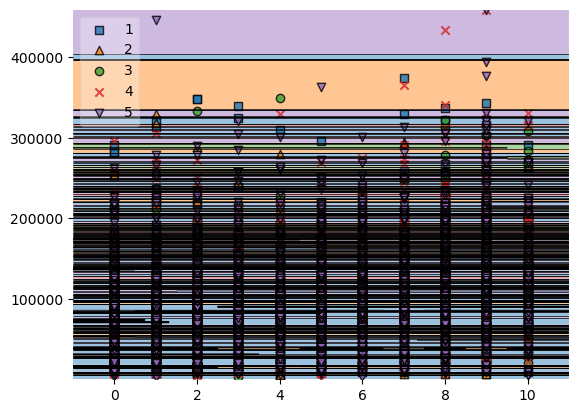

In [22]:
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(np.array(lsRating[['lifetime', 'current_salary']]), np.array(lsRating['average_rating']), clf=lsr_knn, legend=2)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


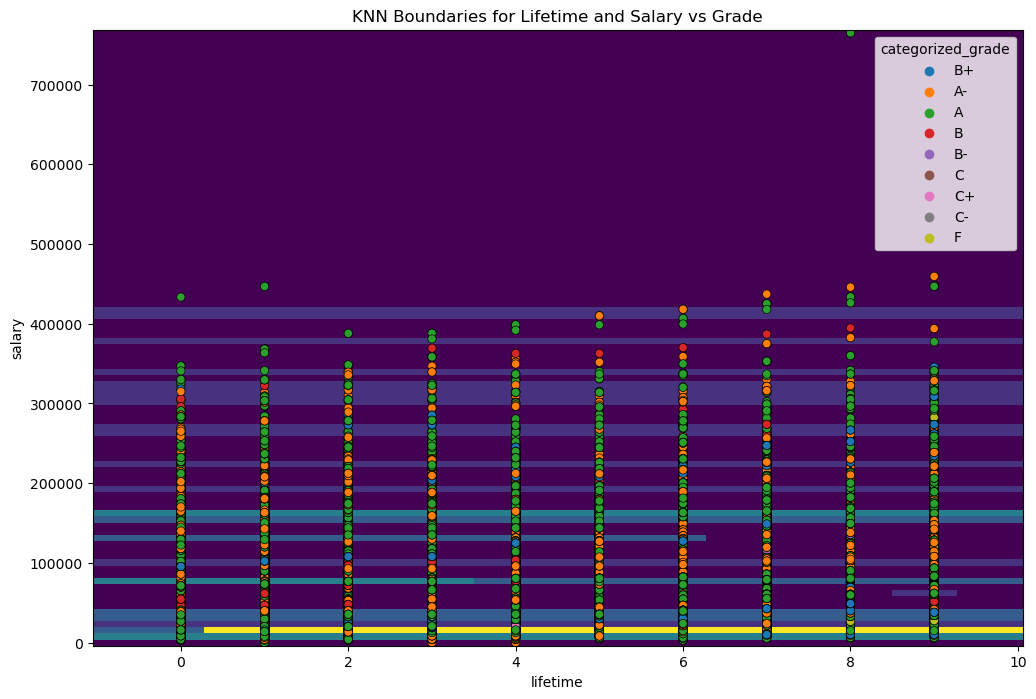

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.inspection import DecisionBoundaryDisplay

# Create color maps
cmap_light = ListedColormap(["red", "orange", "cornflowerblue", 'pink', 'lightgreen'])
cmap_bold = ["darkred", "darkorange", "darkblue", 'magenta', 'darkgreen']

X=lsGrades[['lifetime', 'current_salary']]
y = lsGrades['categorized_grade']

fig, ax = plt.subplots(figsize=(12,8))
DecisionBoundaryDisplay.from_estimator(
    lsg_knn,
    X,
    ax=ax,
    response_method="predict",
    plot_method="pcolormesh",
    xlabel='lifetime',
    ylabel='salary',
    shading="auto",
)

# Plot also the training points
sns.scatterplot(
    x=X['lifetime'],
    y=X['current_salary'],
    hue=y,
    alpha=1.0,
    edgecolor="black",
)
plt.title(
    "KNN Boundaries for Lifetime and Salary vs Grade"
)

plt.show()